In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

cot_path = f"./gpt-3.5-turbo-0301_below_average.csv"

cot_df = pd.read_csv(cot_path)

cot_df = cot_df.drop_duplicates()
cot_df = cot_df.drop(columns=["checkpoint", "batch_size", "loading_precision", "seed", "sample", "scoring_method", "prompting_method", "mask_strategy", "mask_accuracy"])
cot_df.to_csv("llm.csv")

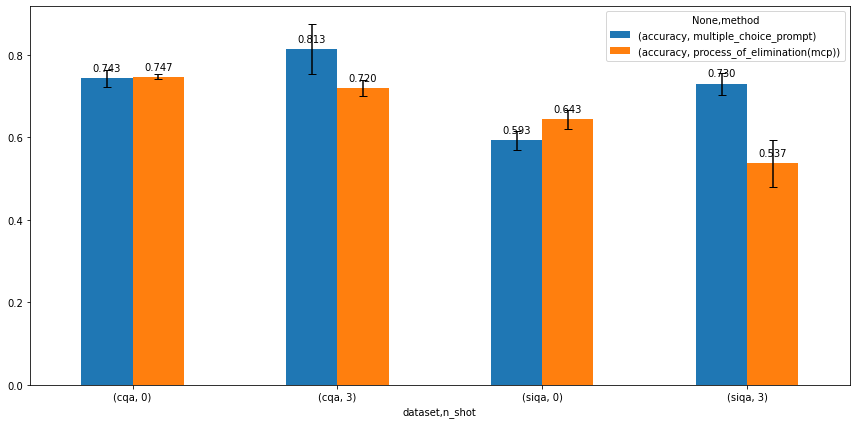

In [4]:
datasets = ["cqa", "siqa"]
vis_df = cot_df[cot_df["dataset"].isin(datasets)]

fig, ax = plt.subplots(figsize=(12, 6))

vis_df = vis_df.groupby(['dataset', 'n_shot', 'method'])
vis_mean = vis_df.mean().unstack()
vis_std = vis_df.std().unstack()

vis_mean.plot.bar(yerr=vis_std, ax=ax, capsize=4, rot=0,)
# plot numbers on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
# plt.savefig("llm.png", dpi=300, bbox_inches='tight')


/tmp/ipykernel_2784/1837024469.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)


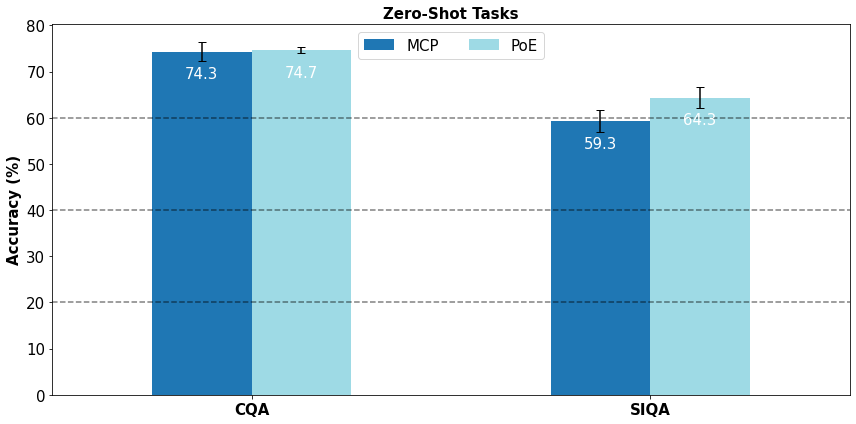

In [6]:
datasets = ["cqa", "siqa"]
n_shot = 0
vis_df = cot_df[(cot_df["dataset"].isin(datasets)) & (cot_df["n_shot"] == n_shot)]

vis_df = vis_df.groupby(['dataset', 'n_shot', 'method'])
vis_mean = vis_df.mean().unstack()
vis_std = vis_df.std().unstack()

for df in [vis_mean, vis_std]:
    df.columns = df.columns.droplevel(0)
    # convert to percentage
    df['multiple_choice_prompt'] = df['multiple_choice_prompt'] * 100
    df['process_of_elimination(mcp)'] = df['process_of_elimination(mcp)'] * 100
    # rename index and columns
    df.index = ["CQA", "SIQA"]
    df.columns = ["MCP", "PoE"]


fig, ax = plt.subplots(figsize=(12, 6))
font_size=15
h_lines = [20, 40, 60] 
vis_mean.plot.bar(yerr=vis_std, 
                  ax=ax, 
                  capsize=4, 
                  rot=0,
                  colormap="tab20",)

# set legend and other stuff
ax.legend(loc='upper center', ncol=2, fontsize=font_size)
ax.set_ylabel("Accuracy (%)", fontsize=font_size, weight='bold')
ax.set_xticklabels(["CQA", "SIQA"], fontsize=font_size, weight='bold')
ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=font_size)
ax.set_title("Zero-Shot Tasks", fontsize=font_size, weight='bold')
# plot numbers on each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height() - 7), 
                color='white',
                fontsize=font_size,
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("llm_0_shot.png", dpi=300, bbox_inches='tight')

In [52]:
ax.get_yticks()

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [8]:
# to produce latex table.


# post processing in latex: repalce table with table*
# add \hline

# change format, and concatenate two strings.
sing_all = vis_mean.applymap(lambda x: f"{x*100:.1f}") + vis_std.applymap(lambda x: f"\\textsubscript{{{x*100:.1f}}}")
method_index = [
                ('accuracy',    'multiple_choice_prompt'), 
                ('accuracy',    'process_of_elimination(mcp)'),]
sing_all = sing_all.reindex(method_index, axis="columns")


latex_means = sing_all.rename(columns={
                                         "multiple_choice_prompt": "MCP",
                                         "process_of_elimination(mcp)": "PoE",
                                         },
                                      #    index={0: "0 shot", 3.0: "3 shot"}
                                       )

latex_means.index = latex_means.index.set_names(["Dataset", "N Shot"])
# transpose the table
# latex_means = latex_means.transpose()

latex_means.style.to_latex(
    buf=f"llm.tex",
    column_format="lcccc",
    position="h",
    position_float="centering",
    label="tab:llm",
    caption="PoE on ChatGPT.",
    multicol_align="c",
    multirow_align="c",
)